This program is the implementation of the second programming assingment of Mining Massive Data (SS-2022). <br>
Date: 15.05.2022 <br>
Authors: Sabo Vladimír, Hoxhallari Kejsi, Bleiberschnig Jakob <br>


#### imports

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix
import timeit
import math
from scipy.stats import cauchy, laplace
import time
from sklearn.svm import SVC # never usend?

#### Classes and Functions used in all three Tasks

In [2]:
def data_process(data):
    features = data[:,:-1]
    features = sklearn.preprocessing.StandardScaler().fit_transform(features)
    features = sklearn.preprocessing.normalize(features)
    data[:,:-1] = features
    return data

def check_accuracy(y, y_pred):
    return sum(y == y_pred)/len(y)

def mc_hinge(W,x,y):

    '''
    w_i - vector of weights of the SVM for the class i; W has |features| rows and |classes| columns
    x - features of a sample
    y - label of a sample
    loss = max{0, max(w_j*x - w_y*x)}, j={0,...,|classes|-1}, j!=y
    output - hingle loss value and the corresponding w_j index
    '''

    n_features, n_class = np.shape(W)
    wyx = W[:,y].dot(x)
    max_dif = - np.inf
    ind_j = 0

    for j in [i for i in range(n_class) if i != y]:
        wjx = W[:,j].dot(x)
        if wjx > max_dif:
            max_dif = wjx
            ind_j = j

    max_dif -= wyx

    if max_dif > 0:
        return 1 + max_dif, ind_j
    else:
        return 0, -1

In [3]:
class LinearSVM:
            
    def fit(self, dataset, learning_rate, epochs, regularization):
        
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        w = np.random.rand(size)        
        w_epochs = np.zeros((epochs, size))       
        
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
                        
            for j in range(len(dataset)):

                x = X[j]                
                y = Y[j]
        
                ywx = y * w.dot(x) 
                    
                if ywx < 1:
                    gradient = (2 * regularization * w) / n - y*x
                else:
                    gradient = (2 * regularization * w) / n
                
                w = w - learning_rate * gradient
            
            w_epochs[i] = w
        
        return w, w_epochs
        
    def predict(self, dataset, w):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)

        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]
        
        for i in range(len(dataset)):
            y[i] = np.sign(np.dot(w.T,dataset[i]))
        return y
    
    def plot_accuracies(self, train_dataset, test_dataset, w_epochs):
        epochs = len(w_epochs)
        test_accuracies = np.zeros(epochs)
        train_accuracies = np.zeros(epochs)
        for i in range(epochs):
            train_labels = self.predict(train_dataset, w_epochs[i])
            test_labels = self.predict(test_dataset, w_epochs[i])
            train_accuracies[i] = check_accuracy(train_dataset[:,-1], train_labels)
            test_accuracies[i] = check_accuracy(test_dataset[:,-1], test_labels)
            

        xs = np.array(range(epochs))+1
        fig = plt.figure(figsize=(7,7))
        ax = plt.axes()
        ax.grid(True)
        ax.set(xlabel="epochs", ylabel="accuracy", ylim=(0,1.1))
        line = ax.plot(xs, train_accuracies, marker='.', label='training') #, marker='o'
        line = ax.plot(xs, test_accuracies, marker='.', label='validation') #, marker='o'
        ax.legend()
        plt.title("Classification Accuracy over Epochs")
        plt.show()



In [4]:
class LinearSVM_MC:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization, n_class):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        W = np.random.rand(size, n_class)       
        
        # this array stores the W matrix after each epoch
        W_epochs = np.zeros((epochs, size, n_class))       
        
        w_norms = []

        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
            
            for j in range(len(dataset)):
                x = X[j]                
                y = int(Y[j])
                
                gradient = np.zeros([size, n_class])
        
                temp, k = mc_hinge(W, x, y)
                    
                if temp > 0:
                    
                    gradient[:,y] = -x

                    gradient[:,k] = x
                    
                
                W = W - learning_rate * (gradient + (2 * regularization * W) / n)
                
                
                '''
                W = W - learning_rate * gradient / n
                
                temp = np.linalg.norm(W, ord='fro')
                if temp > 1/regularization:
                    W /= (temp * regularization)
                '''
            W_epochs[i] = W
            
        w_norms = np.array(w_norms)
        
        return W, W_epochs
        
    def predict(self, dataset, W):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]
        for i in range(len(dataset)):
            y[i] = np.argmax(np.dot(W.T, dataset[i]))
        return y
    
    
    def plot_accuracies(self, train_dataset, test_dataset, W_epochs):
        epochs = len(W_epochs)
        test_accuracies = np.zeros(epochs)
        train_accuracies = np.zeros(epochs)
        for i in range(epochs):
            train_labels = self.predict(train_dataset, W_epochs[i])
            test_labels = self.predict(test_dataset, W_epochs[i])
            train_accuracies[i] = check_accuracy(train_dataset[:,-1], train_labels)
            test_accuracies[i] = check_accuracy(test_dataset[:,-1], test_labels)
            
        
        xs = np.array(range(epochs))+1
        fig = plt.figure(figsize=(7,7))
        ax = plt.axes()
        ax.grid(True)
        ax.set(xlabel="epochs", ylabel="accuracy", ylim=(0,1.1))
        line = ax.plot(xs, train_accuracies, marker='.', label='training') #, marker='o'
        line = ax.plot(xs, test_accuracies, marker='.', label='validation') #, marker='o'
        ax.legend()

        plt.title("Classification Accuracy over Epochs")
        plt.show()


In [5]:
def cross_validation(SVM_object, dataset, no_subsets, learning_rate, epochs, regularization):
    accuracies = np.zeros(no_subsets)
    mean_duration = 0
    # split dataset into no_subsets chunks. Chunks must be of euqal size, otherwise an error is raised
    subarrays = np.split(dataset, no_subsets, axis=0)
    
    # pick one subset as test set and train the model with the rest. Then calculate the accuracy on the test set
    for i in range(no_subsets):
        train_set = np.concatenate(subarrays[:i] + subarrays[i+1:], axis=0)
        test_set = subarrays[i]
        
        start = timeit.default_timer()
        
        w, w_epochs = SVM_object.fit(train_set, learning_rate, epochs, regularization)
        
        stop = timeit.default_timer()
        mean_duration += stop - start
        
        test_labels_pred = SVM_object.predict(test_set, w)
        accuracies[i] = check_accuracy(test_set[:,-1], test_labels_pred)
    
    mean_duration /= no_subsets
    # return the average accuracy
    return np.mean(accuracies), mean_duration

# Task 1: Linear SVM

#### Tiny Toy-Dataset

In [6]:
# read the small toy-dataset and apply preconditioning
toydata_tiny = pd.read_csv('toydata_tiny.csv').to_numpy()
#toydata_tiny = data_process(toydata_tiny)

In [7]:
# create the SVM model
mySVM_linear_tiny = LinearSVM()
regularization = 0.001
learning_rate = 1
epochs = 10

In [8]:
# apply 5 fold cross validation. 
no_subsets = 5
cross_val_accuracy, mean_duration = cross_validation(mySVM_linear_tiny, toydata_tiny, no_subsets, learning_rate, epochs, regularization)
print('Average time for fitting the model: ', mean_duration, 's')  
print("Average Accuracy (Cross Validation): " + str(cross_val_accuracy))

Average time for fitting the model:  0.008331339999858755 s
Average Accuracy (Cross Validation): 0.99


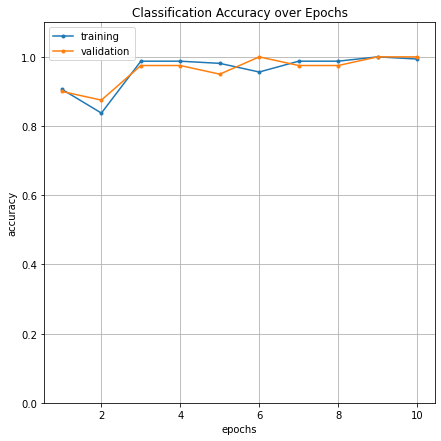

In [9]:
# plotting the convergence, i.e. the accuracy over the number of epochs 

# create random indices from 0 to len(toydata_tiny) 
idx_arr = np.array(range(len(toydata_tiny)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(toydata_tiny))

#split training and test set from toydata_tiny
train_set_tiny = toydata_tiny[idx_arr[:-testsize]]
test_set_tiny = toydata_tiny[idx_arr[-testsize:]]

# fit the model with the training set
w, w_epochs = mySVM_linear_tiny.fit(train_set_tiny , learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_linear_tiny.plot_accuracies(train_set_tiny,test_set_tiny, w_epochs)

#### Large Toy-Dataset

In [10]:
# read the large toy-dataset and apply preconditioning
toydata_large = pd.read_csv('toydata_large.csv').to_numpy()
#toydata_large = data_process(toydata_large)

In [11]:
# create the SVM model
mySVM_linear_large = LinearSVM()
regularization = 0.001
learning_rate = 1
epochs = 10

In [12]:
# apply 5 fold cross validation. 
no_subsets = 5

cross_val_accuracy, mean_duration = cross_validation(mySVM_linear_large, toydata_large, no_subsets, learning_rate, epochs, regularization)
print('Average time for fitting the model: ', mean_duration, 's')  
print("Average Accuracy (Cross Validation): " + str(cross_val_accuracy))

Average time for fitting the model:  5.755007100000148 s
Average Accuracy (Cross Validation): 0.9999800000000001


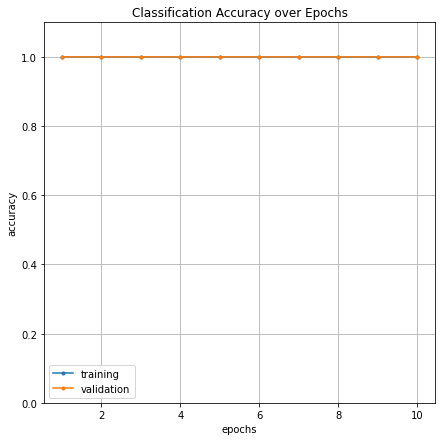

In [13]:
# create random indices from 0 to len(toydata_large) 
idx_arr = np.array(range(len(toydata_large)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(toydata_large))

#split training and test set from toydata_large
train_set_large = toydata_large[idx_arr[:-testsize]]
test_set_large = toydata_large[idx_arr[-testsize:]]

# fit the model with the training set
w, w_epochs = mySVM_linear_large.fit(train_set_large, learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_linear_large.plot_accuracies(train_set_large, test_set_large, w_epochs)

#### MNIST Dataset - Multiclass SVM

In [14]:
# reading MNIST Data and preparing it

data = np.load("mnist.npz")
train = data["train"].T
train_labels = data["train_labels"][0]
test = data["test"].T
test_labels = data["test_labels"][0]

# size of the validation set
validation_size = 10000

# creates a randomly shuffled indices
# the 60000 training dataset must be shuffled before a validation set can be separated from it
idx_arr = np.array(range(len(train_labels)))
np.random.shuffle(idx_arr)

# trainig data
mnist_train = np.zeros([len(train) - validation_size, len(train[0])+1])
mnist_train[:,:-1] = train[idx_arr[:-validation_size]]
mnist_train[:,-1] = train_labels[idx_arr[:-validation_size]]

# validation data
mnist_validation = np.zeros([validation_size, len(train[0])+1])
mnist_validation[:,:-1] = train[idx_arr[-validation_size:]]
mnist_validation[:,-1] = train_labels[idx_arr[-validation_size:]]

# test data (never touch unless for final validation)
mnist_test = np.zeros([len(test), len(test[0])+1])
mnist_test[:,:-1] = test
mnist_test[:,-1] = test_labels

In [15]:
# Create multiclass model and fit the training data

mySVM_linear_mnist = LinearSVM_MC()

regularization = 0.001
learning_rate = 0.001
epochs = 10

start = timeit.default_timer()
W, W_epochs = mySVM_linear_mnist.fit(mnist_train, learning_rate, epochs, regularization, n_class=10)
stop = timeit.default_timer()

print('Time for fitting the model: ', stop - start)  

Time for fitting the model:  19.94012389999989


In [16]:
# calculate accuracies for training and validation sets

train_labels_predicted = mySVM_linear_mnist.predict(mnist_train, W)
validation_labels_predicted = mySVM_linear_mnist.predict(mnist_validation, W)
test_labels_predicted = mySVM_linear_mnist.predict(mnist_test, W)

print("Accuracy of Training Set: ", check_accuracy(mnist_train[:,-1], train_labels_predicted))
print("Accuracy of Validation Set: ", check_accuracy(mnist_validation[:,-1], validation_labels_predicted))
print("Accuracy of Test Set: ", check_accuracy(mnist_test[:,-1], test_labels_predicted))

Accuracy of Training Set:  0.88446
Accuracy of Validation Set:  0.8706
Accuracy of Test Set:  0.8786


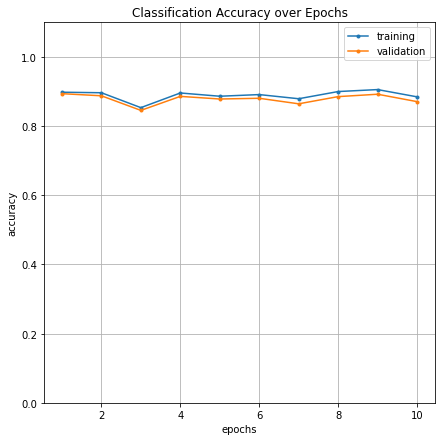

array([[ 939,    0,    5,    0,    1,    6,    5,    1,    6,    0],
       [   0,  935,   44,   27,    1,    9,    1,   34,   43,    1],
       [  14,    5,  838,   25,    7,   12,   10,   16,   30,    5],
       [  10,    0,   24,  857,    0,   71,    2,   14,   52,   11],
       [   5,    2,    1,    3,  770,   11,   14,   17,   24,   97],
       [  16,    0,    6,   18,    8,  766,   11,    6,   74,    1],
       [  10,    2,    6,    1,    6,   65,  918,    2,   13,    2],
       [   3,    1,    6,   11,    1,    5,    1, 1004,    7,   18],
       [  12,    1,   12,   17,    2,   61,    7,    7,  840,   10],
       [   5,    1,    0,   16,   13,   21,    0,  118,   25,  839]],
      dtype=int64)

In [17]:
# plot the accuracies over all epochs
mySVM_linear_mnist.plot_accuracies(mnist_train, mnist_validation, W_epochs)

# print confusion matrix of validation set
confusion_matrix(mnist_validation[:,-1], validation_labels_predicted) #,labels=[0,1,2,3,4,5,6,7,8,9]

# Task 2: Random Fourier Features

#### Functions

In [18]:
def rff(X_train, gamma, d=300):
    
    n_samples, n_features = X_train.shape

    #using Laplacian
    W = cauchy.rvs(scale = gamma, size=(d,n_features))
    b =  2*np.pi*np.random.rand(d)
    
    X_new_train = np.sqrt(2/d) * np.cos((X_train.dot(W.T) + b[np.newaxis,:]))
   
    return X_new_train

In [19]:
def process_train_test_data_rff(train_data):

    n_samples, n_features = train_data[:,:-1].shape
    features_train = rff(train_data, 1/n_features)

    return np.c_[features_train,train_data[:,-1:]]

In [20]:
def rff_MC(X_train,X_val, gamma, d):
    
    n_samples, n_features = X_train.shape
    
    # generates random numbers of the distribution function 1/(pi * (1+x^2))
    W = cauchy.rvs(scale = gamma, size=(d,n_features))
    b =  2*np.pi*np.random.rand(d)

    X_new_train = np.sqrt(2/n_features) * np.cos((X_train.dot(W.T) + b[np.newaxis,:]))
    X_new_validation = np.sqrt(2/n_features) * np.cos((X_val.dot(W.T) + b[np.newaxis,:]))
   
    return X_new_train,X_new_validation

In [21]:
def process_train_test_data_rff_MC(train_data,val_data,d):

    n_samples, n_features = train_data.shape
    features_train,features_val = rff_MC(train_data[:,:-1],val_data[:,:-1], 150,d) #1/n_features

    return np.c_[features_train,train_data[:,-1]], np.c_[features_val,val_data[:,-1]]

#### Small Toy-Dataset

In [22]:
# read the small toy-dataset and apply preconditioning
rff_toydata_tiny = pd.read_csv('toydata_tiny.csv').to_numpy()
rff_toydata_tiny = data_process(rff_toydata_tiny)

rff_toydata_tiny = process_train_test_data_rff(rff_toydata_tiny)

In [23]:
# create the SVM model
mySVM_rff_tiny = LinearSVM()
regularization = 0.1
learning_rate = 1
epochs = 10

In [24]:
# apply 5 fold cross validation. 
no_subsets = 5
cross_val_accuracy, mean_duration = cross_validation(mySVM_rff_tiny, rff_toydata_tiny, no_subsets, learning_rate, epochs, regularization)
print('Average time for fitting the model: ', mean_duration, 's')  
print("Average Accuracy: " + str(cross_val_accuracy))

Average time for fitting the model:  0.007892619999984163 s
Average Accuracy: 1.0


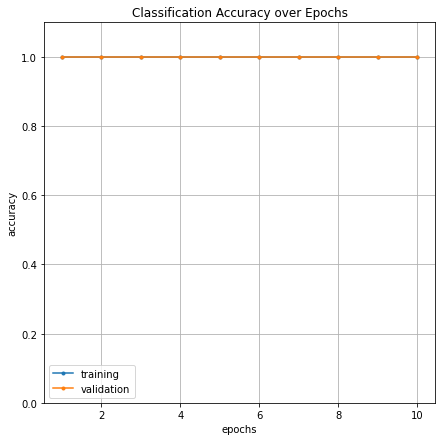

In [25]:
# plotting the convergence, i.e. the accuracy over the number of epochs 

# create random indices from 0 to len(toydata_tiny) 
idx_arr = np.array(range(len(rff_toydata_tiny)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(rff_toydata_tiny))

#split training and test set from rff_toydata_tiny
rff_train_set_tiny = rff_toydata_tiny[idx_arr[:-testsize]]
rff_test_set_tiny = rff_toydata_tiny[idx_arr[-testsize:]]

""" t0 = time.time()
clf = LinearSVC(dual=False)
clf.fit(new_train_X, train_set_tiny[:,-1])
print("done in %0.3fs" % (time.time() - t0))

t1 = time.time()
accuracy = clf.score(new_test_X, test_set_tiny[:,-1])
print("done in %0.3fs" % (time.time() - t1))
print("classification accuracy: %0.3f" % accuracy)
"""

# fit the model with the training set
w, w_epochs = mySVM_rff_tiny.fit(rff_train_set_tiny , learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_rff_tiny.plot_accuracies(rff_train_set_tiny,rff_test_set_tiny, w_epochs)

#### Large Toy-Dataset

In [26]:
# read the large toy-dataset and apply preconditioning
rff_toydata_large = pd.read_csv('toydata_large.csv').to_numpy()
rff_toydata_large = data_process(rff_toydata_large)
rff_toydata_large = process_train_test_data_rff(rff_toydata_large)

In [27]:
# create the SVM model
mySVM_rff_large = LinearSVM()
regularization = 0.1
learning_rate = 1
epochs = 10

In [28]:
# apply 5 fold cross validation. 
no_subsets = 5

cross_val_accuracy, mean_duration = cross_validation(mySVM_rff_large, rff_toydata_large, no_subsets, learning_rate, epochs, regularization)
print('Average time for fitting the model: ', mean_duration, 's')  
print("Average Accuracy: " + str(cross_val_accuracy))

Average time for fitting the model:  8.646160940000845 s
Average Accuracy: 1.0


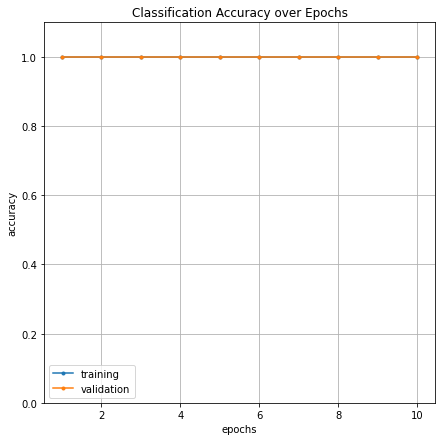

In [29]:
# create random indices from 0 to len(toydata_large) 
idx_arr = np.array(range(len(rff_toydata_large)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(rff_toydata_large))

#split training and test set from toydata_large
rff_train_set_large = rff_toydata_large[idx_arr[:-testsize]]
rff_test_set_large = rff_toydata_large[idx_arr[-testsize:]]

# fit the model with the training set
w, w_epochs = mySVM_rff_large.fit(rff_train_set_large, learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_rff_large.plot_accuracies(rff_train_set_large, rff_test_set_large, w_epochs)

#### MNIST Dataset - Multiclass SVM

In [30]:
# reading MNIST data from file and preparing it

data = np.load("mnist.npz")
train = data["train"].T
train_labels = data["train_labels"][0]
test = data["test"].T
test_labels = data["test_labels"][0]

# size of the validation set
validation_size = 10000

# creates randomly shuffled indices
# the 60000 training dataset must be shuffled before a validation set can be separated from it
idx_arr = np.array(range(len(train_labels)))
np.random.shuffle(idx_arr)

# trainig data
mnist_train = np.zeros([len(train) - validation_size, len(train[0])+1])
mnist_train[:,:-1] = train[idx_arr[:-validation_size]]
mnist_train[:,-1] = train_labels[idx_arr[:-validation_size]]

# validation data
mnist_validation = np.zeros([validation_size, len(train[0])+1])
mnist_validation[:,:-1] = train[idx_arr[-validation_size:]]
mnist_validation[:,-1] = train_labels[idx_arr[-validation_size:]]

# test data (never touch unless for final validation)
#mnist_test = np.zeros([len(test), len(test[0])+1])
#mnist_test[:,:-1] = test
#mnist_test[:,-1] = test_labels



In [31]:
# Create multiclass model and fit the training data

mySVM_rff_mnist = LinearSVM_MC()

regularization = 0.1
learning_rate = 1
epochs = 10
d = 1000
rff_mnist_train,rff_mnist_validation  = process_train_test_data_rff_MC(mnist_train,mnist_validation,d)

start = timeit.default_timer()
W, W_epochs = mySVM_rff_mnist.fit(rff_mnist_train, learning_rate, epochs, regularization, n_class=10)
stop = timeit.default_timer()

print('Time for fitting the model: ', stop - start, '\n')

# calculate accuracies for training and validation sets

#train_labels_predicted = mySVM_rff_mnist.predict(rff_mnist_train, W)
#validation_labels_predicted = mySVM_rff_mnist.predict(rff_mnist_validation, W)
#print("Accuracy of Training Set: ", check_accuracy(rff_mnist_train[:,-1], train_labels_predicted))
#print("Accuracy of Validation Set: ", check_accuracy(rff_mnist_validation[:,-1], validation_labels_predicted))

Time for fitting the model:  25.727691300000515 



In [32]:
# predict training and validation sets and calculate accuracy

train_labels_predicted = mySVM_rff_mnist.predict(rff_mnist_train, W)
validation_labels_predicted = mySVM_rff_mnist.predict(rff_mnist_validation, W)
    
train_accuracy = check_accuracy(rff_mnist_train[:,-1], train_labels_predicted)
validation_accuracy = check_accuracy(rff_mnist_validation[:,-1], validation_labels_predicted)

print("Accuracy of Training Set: ", train_accuracy)
print("Accuracy of Validation Set: ", validation_accuracy)
#print("Accuracy of Test Set: ", check_accuracy(mnist_test[:,-1], test_labels_predicted))

Accuracy of Training Set:  0.12664
Accuracy of Validation Set:  0.1029


In [33]:
# prints accuracies for different number of RFFs 

train_accuracies = []
for k in range(3):
    
    rff_mnist_train,rff_mnist_validation  = process_train_test_data_rff_MC(mnist_train,mnist_validation,1000*k)
    W, W_epochs = mySVM_rff_mnist.fit(rff_mnist_train, learning_rate, epochs, regularization, n_class=10)
    train_labels_predicted = mySVM_rff_mnist.predict(rff_mnist_train, W)
    
    train_accuracies.append(check_accuracy(rff_mnist_train[:,-1], train_labels_predicted))
print(train_accuracies)  

[0.10196, 0.12666, 0.14756]


In [ ]:
# plot the accuracies over all epochs
#mySVM_rff_mnist.plot_accuracies(rff_mnist_train, rff_mnist_validation, W_epochs)

# print confusion matrix of validation set
#confusion_matrix(rff_mnist_validation[:,-1], validation_labels_predicted) #,labels=[0,1,2,3,4,5,6,7,8,9]

# Task 3: Parallel SVM

In [247]:
def parallel_SVM(SVM_object, dataset, n_machines, learning_rate, epochs, regularization, mc=False, verbose=False, stats=False):
    # initiate timer for total run time and thread average counter
    time_tot_start = time.perf_counter()
    time_thread_avg = 0
    
    # shuffle data and split them into equal batches for all machines/threads
    batch = math.floor(len(dataset)/n_machines)
    shuffle = np.random.permutation(len(dataset))
    dataset = dataset[shuffle]
    
    # create a weight vector/matrix
    if mc:
        v = np.zeros([len(dataset[0]), 10])
    else:
        v = np.zeros(len(dataset[0]))
    
    # run SVM on every machine/thread with its corresponding data batch, record times
    for i in range(n_machines):
        time_thread_start = time.perf_counter()
        
        if mc:
            w, _ = SVM_object.fit(dataset[i*batch:(i+1)*batch], learning_rate, epochs, regularization, 10)
        else:
            w, _ = SVM_object.fit(dataset[i*batch:(i+1)*batch], learning_rate, epochs, regularization)
            
        v += w
        
        time_thread_end = time.perf_counter()
        time_thread_avg += time_thread_end - time_thread_start
        
    # average weight vector/matrix over all machines
    v /= n_machines
    
    # print out accuracy
    if stats:
        y_pred = SVM_object.predict(dataset, v)
        print('Achieved accuracy: '+str(round(check_accuracy(dataset[:,-1], y_pred)*100,2))+'%.')
        
    time_tot_end = time.perf_counter()
    
    # print out total accumulated time and time per machine/thread
    if verbose:
        print('Total run time: '+str(round(time_tot_end-time_tot_start, 2))+' seconds.')
        print('Average time for one pseudo-thread: '+str(round(time_thread_avg/n_machines, 3))+' seconds.')
        print('Used '+str(n_machines)+' machine(s) over '+str(epochs)+' epoch(s).')
        print('Regularization parameter: '+str(regularization)+', learning rate: '+str(learning_rate)+'.')
    return v

In [248]:
# Toydata tiny
svm_obj1 = LinearSVM()
v = parallel_SVM(svm_obj1, toydata_tiny, 2, 0.01, 10, 0.1, verbose=True, stats=True)

Achieved accuracy: 97.0%.
Total run time: 0.01 seconds.
Average time for one pseudo-thread: 0.005 seconds.
Used 2 machines over 10 epochs.
Regularization parameter: 0.1, learning rate: 0.01.


In [249]:
# Toydata large
svm_obj2 = LinearSVM()
v = parallel_SVM(svm_obj2, toydata_large, 1, 1, 1, 1, verbose=True, stats=True)

Achieved accuracy: 100.0%.
Total run time: 1.5 seconds.
Average time for one pseudo-thread: 0.744 seconds.
Used 1 machines over 1 epochs.
Regularization parameter: 1, learning rate: 1.


In [250]:
# MNIST
svm_obj3 = LinearSVM_MC()
v = parallel_SVM(svm_obj3, mnist_train, 6, 0.01, 10, 0.1, mc=True, verbose=True, stats=True)

Achieved accuracy: 92.32%.
Total run time: 20.39 seconds.
Average time for one pseudo-thread: 3.282 seconds.
Used 6 machines over 10 epochs.
Regularization parameter: 0.1, learning rate: 0.01.


In [251]:
# Validation accuracy on MNIST
valid_labels = svm_obj3.predict(mnist_validation, v)
valid_acc = check_accuracy(mnist_validation[:,-1], valid_labels)
print('Classification accuracy on the MNIST validation data: '+str(valid_acc*100)+ '%.')

Classification accuracy on the MNIST validation data: 91.97%.


In [252]:
# Retrain MNIST with both training and validation data, keeping the parameters fixed
mnist_trainvalid = np.concatenate((mnist_train, mnist_validation), axis=0)
v = parallel_SVM(svm_obj3, mnist_trainvalid, 6, 0.01, 10, 0.1, mc=True, verbose=True, stats=True)

Achieved accuracy: 92.22%.
Total run time: 24.49 seconds.
Average time for one pseudo-thread: 3.948 seconds.
Used 6 machines over 10 epochs.
Regularization parameter: 0.1, learning rate: 0.01.


In [253]:
# Test accuracy on MNIST
test_labels = svm_obj3.predict(mnist_test, v)
test_acc = check_accuracy(mnist_test[:,-1], test_labels)
print('Classification accuracy on the MNIST test data: '+str(test_acc*100)+ '%.')

Classification accuracy on the MNIST test data: 92.05%.
